In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [2]:
import numpy as np
import networkx as nx
import pandas as pd

# Import our refactored functions
from scripts import (
    load_graph_from_csv,
    create_graphs,
    calculate_distance_matrices,
    solve_pmedian_problem,
    extract_distances_from_solution,
    create_results_dataframe,
    draw_graph_with_centers,
    plot_multiple_quantile_distributions,
    prune_leaf_nodes
)

In [3]:
CSV_FILE = 'data/graphs/Tata_upd.csv'
NUM_FACILITIES = 6  # Number of centers to place (p parameter)
SOLVER_PATH = '/usr/local/bin/glpsol'  # Configurable solver path

In [4]:
print("Loading and preprocessing graph data...")
edges_data = load_graph_from_csv(CSV_FILE, weight_value=1.0)
print(f"Loaded {len(edges_data)} unique edges")

print("Creating graph representations...")
TT_ig, TT = create_graphs(edges_data)
print(f"Created graphs with {TT_ig.vcount()} vertices and {TT_ig.ecount()} edges")

Loading and preprocessing graph data...
Loaded 177 unique edges
Creating graph representations...
Created graphs with 136 vertices and 177 edges


In [5]:
print("Calculating distance matrices...")
protected_data, resistance_data, distance_data = calculate_distance_matrices(TT_ig, TT)
print(f"- Protected distances: {protected_data.shape}")
print(f"- Resistance distances: {resistance_data.shape}")
print(f"- Geodesic distances: {distance_data.shape}")

# Create protected distance dictionary for analysis
from scripts.graph_operations import graph_distances_dict

# Get protected distances as dictionary for compatibility with existing analysis functions
vertex_names = TT_ig.vs["name"] if "name" in TT_ig.vs.attributes() else list(range(TT_ig.vcount()))
prot_dict = {}
for i, row_name in enumerate(protected_data.index):
    for j, col_name in enumerate(protected_data.columns):
        prot_dict[(row_name, col_name)] = protected_data.loc[row_name, col_name]


Calculating distance matrices...
No speed attributes found. Using standard protected distances...


100%|██████████| 177/177 [00:02<00:00, 79.38it/s]


- Protected distances: (136, 136)
- Resistance distances: (136, 136)
- Geodesic distances: (136, 136)


In [6]:
def get_max_from_result_dict(result_dict, prot_dict):
    """
    Возвращает максимальное значение из списка, сформированного на основе result_dict и prot_dict.

    :param result_dict: Словарь с ключами (места) и значениями (список клиентов).
    :param prot_dict: Словарь с возможными парами (ключами) и значениями.
    :return: Максимальное значение из сформированного списка или None, если список пуст.
    """
    result_list = []

    for i in result_dict.keys():
        for u in result_dict[i]:
            try:
                # Попытка взять значение из prot_dict[i][u]
                value = prot_dict[(i, u)]
            except KeyError:
                try:
                    # Если не получилось, пытаемся взять из prot_dict[u][i]
                    value = prot_dict[(u, i)]
                except KeyError:
                    # Если ни один ключ не найден, пропускаем
                    value = None
            if value is not None:
                result_list.append(int(value))

    # Возвращаем максимум или None, если список пуст
    return max(result_list) if result_list else None


def optimize_and_compute_max(input_data, p_range, glpk_path, prot_dict):
    """
    Вызывает solve_pmedian_problem для каждого p из p_range, затем вычисляет максимум через get_max_from_result_dict.

    :param input_data: DataFrame с матрицей расстояний или затрат.
    :param p_range: Итерабельный объект с диапазоном значений p.
    :param glpk_path: Путь к исполняемому файлу glpsol.
    :param prot_dict: Словарь с парами (ключами) и их значениями для расчёта максимумов.
    :return: Список словарей с результатами для каждого p.
    """
    results = []

    for p in p_range:
        print(f"Solving P-median problem for p={p}...")
        
        # Шаг 1: Оптимизация для текущего значения p с использованием новой функции
        result_dict = solve_pmedian_problem(
            input_data,
            p,
            solver_path=glpk_path,
            verbose=False,
            use_heuristic_solution=False,

        )

        # Шаг 2: Вычисление максимального значения
        max_value = get_max_from_result_dict(result_dict, prot_dict)

        # Шаг 3: Сохранение результата
        results.append({
            "p": p,
            "max_value": max_value
        })

    return results

In [7]:
# Configuration
glpk_path = '/usr/local/bin/glpsol'
p_range = [i for i in range(1, 10)]

print(f"Solver path: {glpk_path}")
print(f"Testing p values: {p_range}")

Solver path: /usr/local/bin/glpsol
Testing p values: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
print("Solving P-median problems with geodesic distances...")
results_geodesic = optimize_and_compute_max(distance_data, p_range, glpk_path, prot_dict)

Solving P-median problems with geodesic distances...
Solving P-median problem for p=1...
Computing warm start solution with Teitz-Bart heuristic...
Starting Teitz and Bart heuristic...
Initial random solution cost: 1226
Found improvement: 286.00. New cost: 940.00
No further improvements possible. Heuristic finished.
Heuristic solution objective: 940.00
Heuristic facilities: ['95']
Parameters
Variables
Objective function
Constraints
Setting warm start values...
Warm start values set successfully.
Initializing solver
Starting exact solving
Solving P-median problem for p=2...
Computing warm start solution with Teitz-Bart heuristic...
Starting Teitz and Bart heuristic...
Initial random solution cost: 939
Found improvement: 290.00. New cost: 649.00
Found improvement: 35.00. New cost: 614.00
No further improvements possible. Heuristic finished.
Heuristic solution objective: 614.00
Heuristic facilities: ['95', '52']
Parameters
Variables
Objective function
Constraints
Setting warm start values

In [9]:
print("Solving P-median problems with resistance distances...")
results_resistance = optimize_and_compute_max(resistance_data, p_range, glpk_path, prot_dict)

Solving P-median problems with resistance distances...
Solving P-median problem for p=1...
Computing warm start solution with Teitz-Bart heuristic...
Starting Teitz and Bart heuristic...
Initial random solution cost: 455.2634469794706
Found improvement: 103.04. New cost: 352.22
No further improvements possible. Heuristic finished.
Heuristic solution objective: 352.22
Heuristic facilities: ['98']
Parameters
Variables
Objective function
Constraints
Setting warm start values...
Warm start values set successfully.
Initializing solver
Starting exact solving
Solving P-median problem for p=2...
Computing warm start solution with Teitz-Bart heuristic...
Starting Teitz and Bart heuristic...
Initial random solution cost: 382.59222548310214
Found improvement: 86.18. New cost: 296.41
Found improvement: 30.36. New cost: 266.05
Found improvement: 0.22. New cost: 265.83
No further improvements possible. Heuristic finished.
Heuristic solution objective: 265.83
Heuristic facilities: ['120', '52']
Param

In [10]:
print("Solving P-median problems with protected distances...")
results_guf = optimize_and_compute_max(protected_data, p_range, glpk_path, prot_dict)

Solving P-median problems with protected distances...
Solving P-median problem for p=1...
Computing warm start solution with Teitz-Bart heuristic...
Starting Teitz and Bart heuristic...
Initial random solution cost: 2083.0
Found improvement: 756.00. New cost: 1327.00
No further improvements possible. Heuristic finished.
Heuristic solution objective: 1327.00
Heuristic facilities: ['95']
Parameters
Variables
Objective function
Constraints
Setting warm start values...
Warm start values set successfully.
Initializing solver
Starting exact solving
Solving P-median problem for p=2...
Computing warm start solution with Teitz-Bart heuristic...
Starting Teitz and Bart heuristic...
Initial random solution cost: 1495.0
Found improvement: 370.00. New cost: 1125.00
Found improvement: 130.00. New cost: 995.00
Found improvement: 1.00. New cost: 994.00
No further improvements possible. Heuristic finished.
Heuristic solution objective: 994.00
Heuristic facilities: ['52', '120']
Parameters
Variables
Obj

In [11]:
def plot_comparison(results_list, labels):
    """
    Строит график для сравнения массивов max_value из нескольких результатов optimize_and_compute_max.

    :param results_list: Список результатов (массивов словарей) от optimize_and_compute_max.
    :param labels: Список подписей для каждого набора данных.
    """
    if len(results_list) != len(labels):
        raise ValueError("Количество результатов должно совпадать с количеством подписей.")

    plt.figure(figsize=(10, 6))

    for results, label in zip(results_list, labels):
        # Извлекаем значения p и max_value
        p_values = [result['p'] for result in results]
        max_values = [result['max_value'] for result in results]

        # Построение графика
        plt.plot(p_values, max_values, marker='o', label=label, linewidth=2, markersize=6)

    # Настройка графика
    plt.xlabel("Number of facilities", fontsize=12)
    plt.ylabel("Worst distance GUF", fontsize=12)
    plt.title("P-median Coverage Analysis: Worst-case Distance Comparison", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Creating comparison plot...


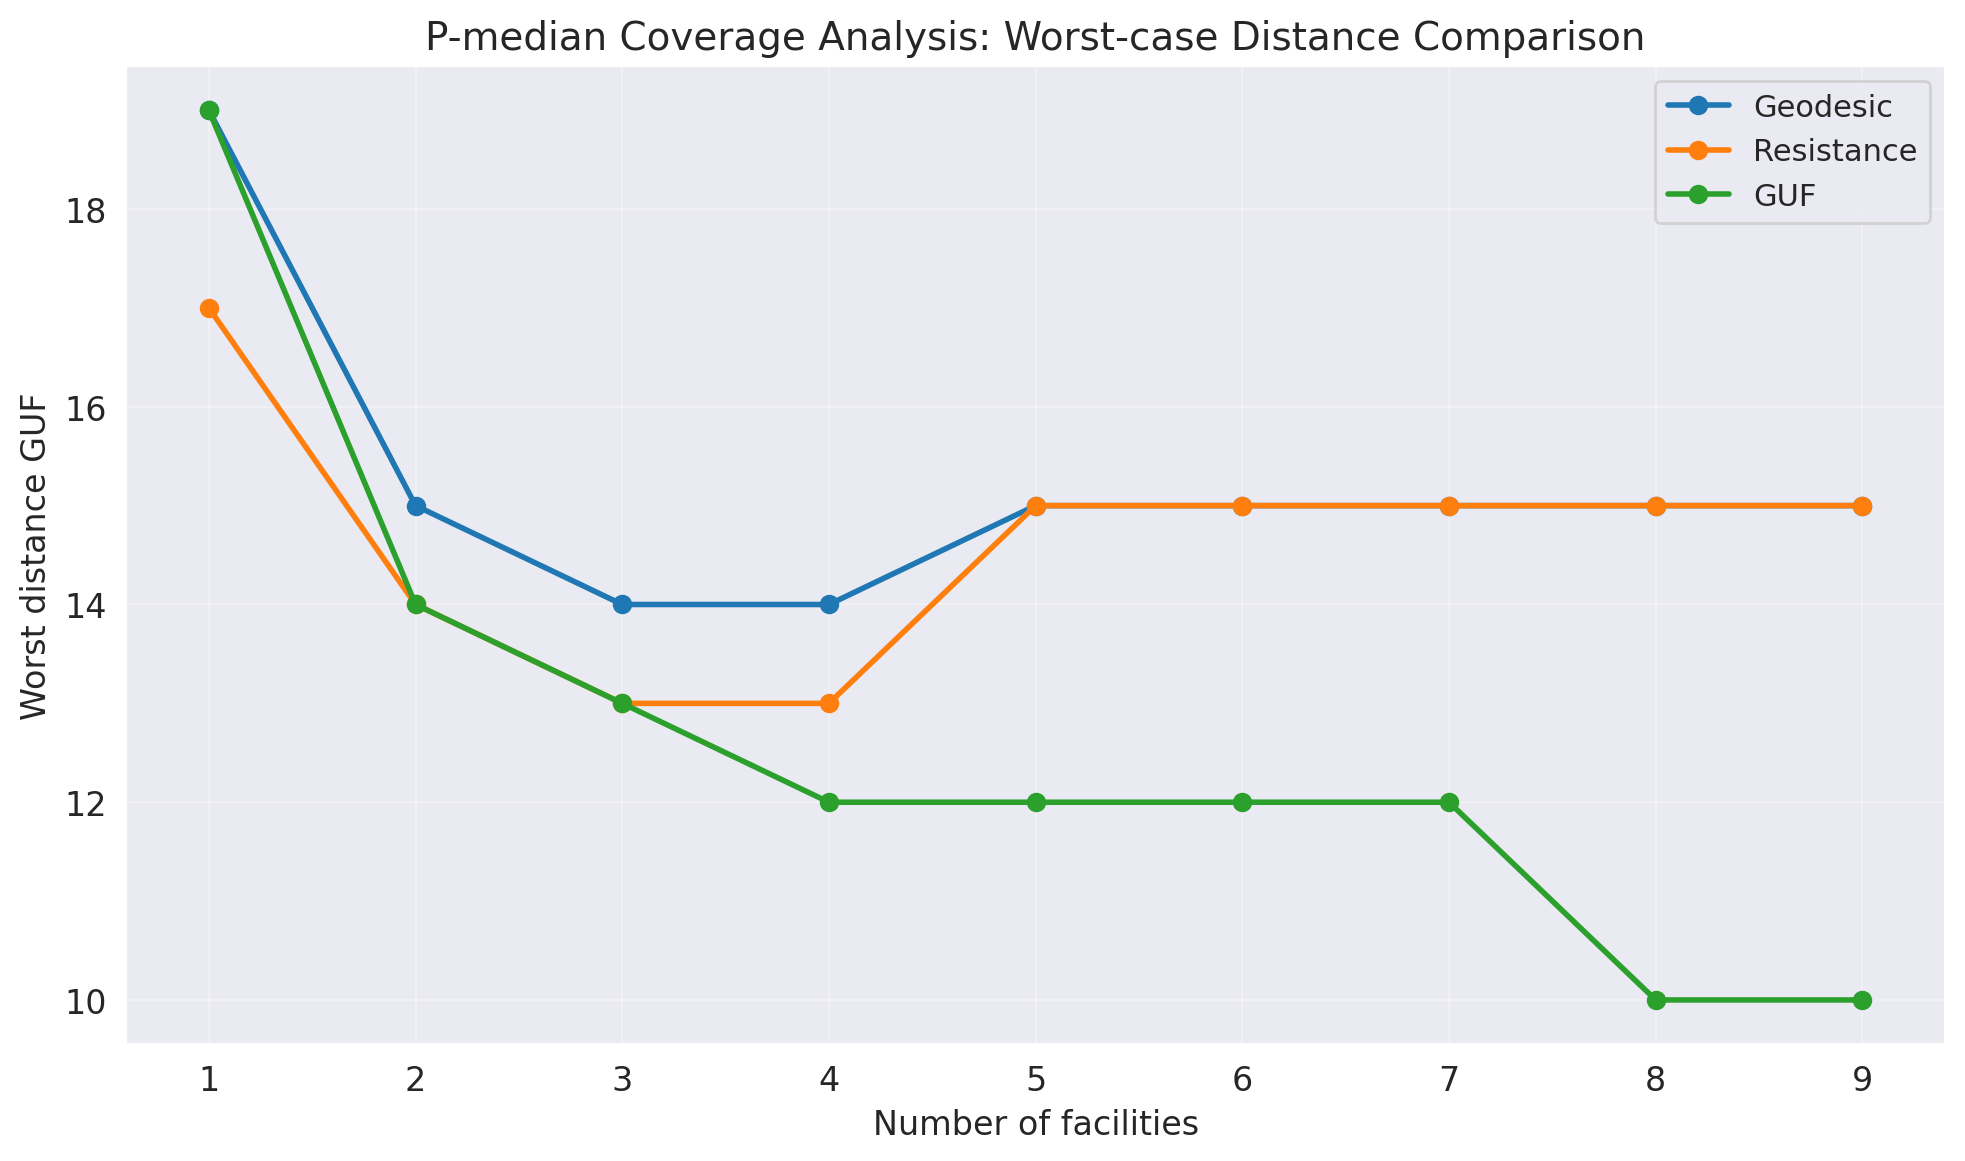


Analysis complete!
COVERAGE ANALYSIS SUMMARY
Graph: 136 vertices, 177 edges
P-values tested: [1, 2, 3, 4, 5, 6, 7, 8, 9]

Final results:
- Geodesic: [19, 15, 14, 14, 15, 15, 15, 15, 15]
- Resistance: [17, 14, 13, 13, 15, 15, 15, 15, 15]
- GUF: [19, 14, 13, 12, 12, 12, 12, 10, 10]


In [12]:
print("Creating comparison plot...")
labels = ["Geodesic", "Resistance", "GUF"]
plot_comparison([results_geodesic, results_resistance, results_guf], labels)

print("\nAnalysis complete!")
print("="*50)
print("COVERAGE ANALYSIS SUMMARY")
print("="*50)
print(f"Graph: {TT_ig.vcount()} vertices, {TT_ig.ecount()} edges")
print(f"P-values tested: {p_range}")
print("\nFinal results:")
print("- Geodesic:", [r['max_value'] for r in results_geodesic])
print("- Resistance:", [r['max_value'] for r in results_resistance])
print("- GUF:", [r['max_value'] for r in results_guf])